In [76]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import collections
from scipy.optimize import curve_fit

In [4]:
import pandas as pd
df=pd.read_csv('data/oilDB.csv',sep=',')

In [5]:
dG=nx.from_pandas_edgelist(df,'exp','imp',['v'],create_using=nx.DiGraph())

In [6]:
G=nx.to_undirected(dG)
for (i,j) in G.edges():
    G[i][j]['weight']=0
    if (i,j) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[i][j]['v']
    if (j,i) in dG.edges():
        G[i][j]['weight']=G[i][j]['weight']+dG[j][i]['v']

In [12]:
list(G.edges(data=True))[:5]

[('Afghanistan',
  'Turkmenistan',
  {'v': 66452.41900000001, 'weight': 66452.41900000001}),
 ('Afghanistan', 'Azerbaijan', {'v': 72687.057, 'weight': 72687.057}),
 ('Afghanistan',
  'Iran',
  {'v': 658642.0929999999, 'weight': 658642.0929999999}),
 ('Afghanistan', 'Spain', {'v': 1939.356, 'weight': 1939.356}),
 ('Afghanistan',
  'United Arab Emirates',
  {'v': 38082.609, 'weight': 38082.609})]

In [7]:
nx.density(G)

0.17997716991502136

# Weight's distribution

In [43]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins,density=True)
    logBins = np.delete(logBins, -1)
    return logBinDensity, logBins

In [44]:
weights=[G[u][v]['weight'] for (u,v) in G.edges()]

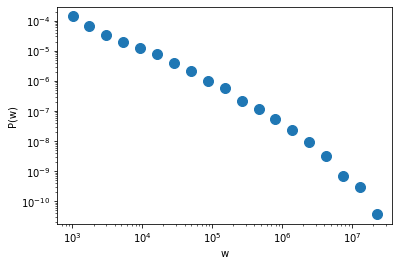

In [50]:
y,x=logBinning(np.array(weights),20)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('w')
plt.ylabel('P(w)')
plt.show()

# Strength distribution

In [60]:
s=list(dict(G.degree(weight='weight')).values())

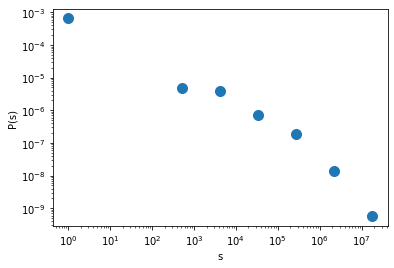

In [62]:
y,x=logBinning(np.array(s),10)
plt.loglog(x,y,'o',markersize=10)
plt.xlabel('s')
plt.ylabel('P(s)')
plt.show()

# Strength degree correlation

In [65]:
k=list(dict(G.degree()).values())

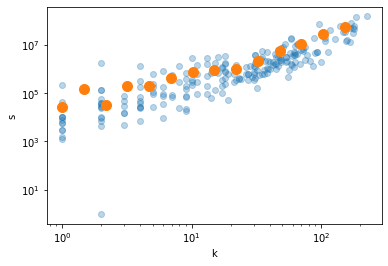

In [77]:
plt.loglog(k,s,'o',alpha=0.3)

logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

In [74]:
def powerLaw(x, a, b):
    return b*x**(a)

1.3063774518377387


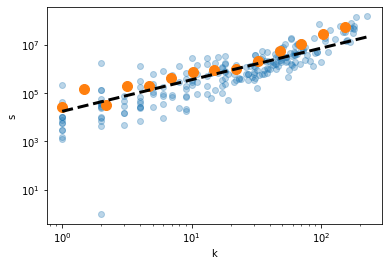

In [92]:
plt.loglog(k,s,'o',alpha=0.3)

logBins=np.logspace(np.log2(np.min(k)),np.log2(np.max(k)),base=2,num=15)
ybin,xbin,binnumber=scipy.stats.binned_statistic(k,s,statistic='mean',bins=logBins)
plt.loglog(xbin[:-1],ybin,'o',markersize=10)

fitx=[i for (i,j) in zip(k,s) if  i<50]
fity=[j for (i,j) in zip(k,s) if i<50]
popt, pcov = curve_fit(powerLaw, fitx, fity)  
#popt, pcov = curve_fit(powerLaw, k, s)  
print (popt[0])
plt.loglog(sorted(k), powerLaw(sorted(k), *popt), '--',c='k',linewidth=3)

plt.xlabel('k')
plt.ylabel('s')
plt.show()

# ROBUSTNESS

### random failures

In [94]:
fList=np.linspace(0,1,20)
NtoRem=[int(i*G.number_of_nodes()) for i in fList]

In [95]:
print(NtoRem)

[0, 11, 22, 34, 45, 57, 68, 80, 91, 103, 114, 126, 137, 149, 160, 172, 183, 195, 206, 218]


In [96]:
import random
sf=[]
for nn in NtoRem[:-1]:
    thisG=G.copy()
    ll=random.sample(G.nodes(),nn)
    thisG.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sf.append(thisSf/float(G.number_of_nodes()))



### attacks

In [97]:
hh=collections.Counter(dict(G.degree())).most_common()
orderedNodes=[u for (u,v) in hh]

In [98]:
print(orderedNodes[:10])

['USA', 'China', 'Netherlands', 'France', 'Germany', 'Russian Federation', 'Belgium', 'Italy', 'Turkey', 'United Arab Emirates']


In [99]:
fList1=np.linspace(0,1,20)
NtoRem=[int(i*G.number_of_nodes()) for i in fList1]

In [100]:
sfAtt=[]
for nn in NtoRem[:-1]:
    thisG=G.copy()
    ll=orderedNodes[:nn]
    thisG.remove_nodes_from(ll)
    thisSf=len(max(sorted(nx.connected_components(thisG), key = len, reverse=True)))
    sfAtt.append(thisSf/float(G.number_of_nodes()))

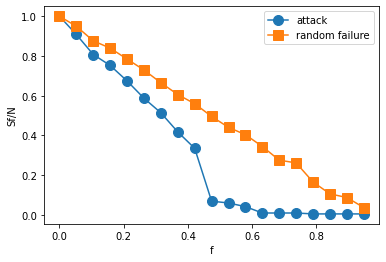

In [101]:
plt.plot(fList1[:-1],sfAtt,'o-',markerSize=10,label='attack')
plt.plot(fList[:-1],sf,'s-',markerSize=10,label='random failure')
plt.xlabel('f')
plt.ylabel('Sf/N')
plt.legend()
plt.show()